In [66]:
!pip install --upgrade pandas-profiling
!pip install --upgrade hypertools
!pip install --upgrade pandas

Requirement already up-to-date: pandas-profiling in /opt/conda/lib/python3.7/site-packages (2.8.0)


Requirement already up-to-date: hypertools in /opt/conda/lib/python3.7/site-packages (0.6.2)
Requirement already up-to-date: pandas in /opt/conda/lib/python3.7/site-packages (1.0.3)


In [67]:
import os
import re
import string
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from nltk import tokenize
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

### Load dataset

In [68]:
base_path = "/kaggle"

# Chech if it's on kaggle environment 
if os.path.exists(base_path):
    input_path = os.path.join(base_path, "input", "tweet-sentiment-extraction")
    output_path = os.path.join(base_path, "working")
else:
    base_path = "data"
    input_path = base_path
    output_path = os.path.join(base_path, "submissions")


train_file = os.path.join(input_path, "train.csv")
test_file = os.path.join(input_path, "test.csv")

In [69]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

### Data analysis

In [70]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [71]:
train_df.sample(n=1)["text"]

15109     I`m the heir to the over draft
Name: text, dtype: object

In [72]:
train_df.dtypes

textID           object
text             object
selected_text    object
sentiment        object
dtype: object

In [73]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [74]:
test_df.dtypes

textID       object
text         object
sentiment    object
dtype: object

In [75]:
print(f"Train size {train_df.shape[0]}")
print(f"Text size {test_df.shape[0]}")

Train size 27481
Text size 3534


In [76]:
f"The 3 sentiments are '{', '.join(train_df.sentiment.unique().tolist())}'"

"The 3 sentiments are 'neutral, negative, positive'"

Count NaNs

In [77]:
print(f"Train NaN's:\n{train_df.isna().sum()}")

Train NaN's:
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [78]:
print(f"Test NaN's:\n{test_df.isna().sum()}")

Test NaN's:
textID       0
text         0
sentiment    0
dtype: int64


### Data Cleaning

In [79]:
train_df.dropna(inplace=True)

In [80]:
train_df.columns

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

## EDA

### Text

In [81]:
# (if selected_text is NaN means that it is from test)
full_df = pd.concat([train_df, test_df])
full_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [82]:
full_df.loc[:, "text_lower"] = full_df.text.str.lower()

Punctuation

In [83]:
def count_punctuations(text):
    text_punctuations = []
    punctuation_list = list(string.punctuation)
    for token in tokenize.word_tokenize(text):
        if not token.isalpha():
            if len(token) > 1: # Example > 1: I'm 
                sub_tokens = list(token)
                for sub_token in sub_tokens:
                    if sub_token in punctuation_list:
                        text_punctuations.append(sub_token)
            else:
                text_punctuations.append(token)
    return pd.Series(text_punctuations).value_counts()

count_punctuation_df = full_df.text.apply(count_punctuations)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


In [84]:
count_punctuation_df.fillna(0, inplace=True)
count_punctuation_df.loc[:, "sentiment"] = full_df.sentiment
grouped_df = count_punctuation_df.groupby("sentiment").sum()

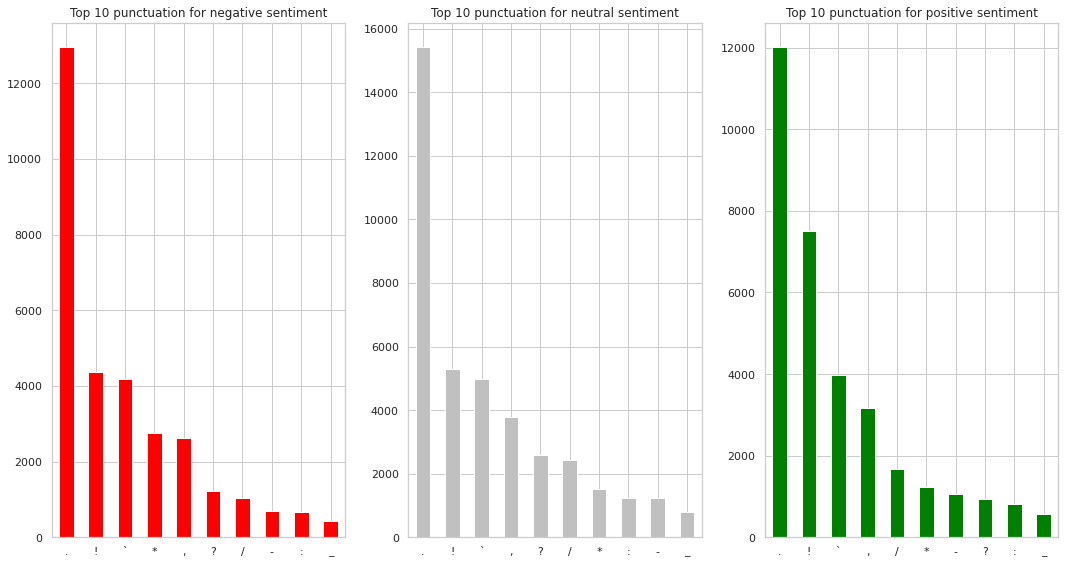

In [90]:
groups = ["negative", "neutral", "positive"]
colors = ["red", "silver", "green"]

fig = plt.figure(figsize=(15, 8))
for i, (group, color) in enumerate(zip(groups, colors), start=1):
    ax = fig.add_subplot(1, 3, i)
    grouped_df.loc[group].sort_values(ascending=False).head(10).plot(
        kind="bar", color=color, title=f"Top 10 punctuation for {group} sentiment", ax=ax, rot=0)

fig.tight_layout()

Text lenght.

Functions for cleaning text

In [86]:
def clean_html_encoding(text):
    text = BeautifulSoup(text, 'lxml').get_text()
    return text

def remove_html_tags(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_urls(text):
    links_reg = re.compile(r'https?://[A-Za-z0-9./]+')
    return links_reg.sub(r'', text)

def remove_mentions(text):
    mentions_reg = re.compile(r'@[A-Za-z0-9]+')
    return mentions_reg.sub(r'', text)

def lower_text(text):
    return text.lower()

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_puntuation(tokens):
    return [token for token in tokens if token.isalpha()]

def clean_text(text):
    text = clean_html_encoding(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_emoji(text)
    
    text = lower_text(text)
    tokens = tokenize.word_tokenize(text)
    tokens = remove_puntuation(tokens)
    
    return " ".join(tokens)

full_df.loc[:, "text_cleaned"] = full_df.text.apply(clean_text)

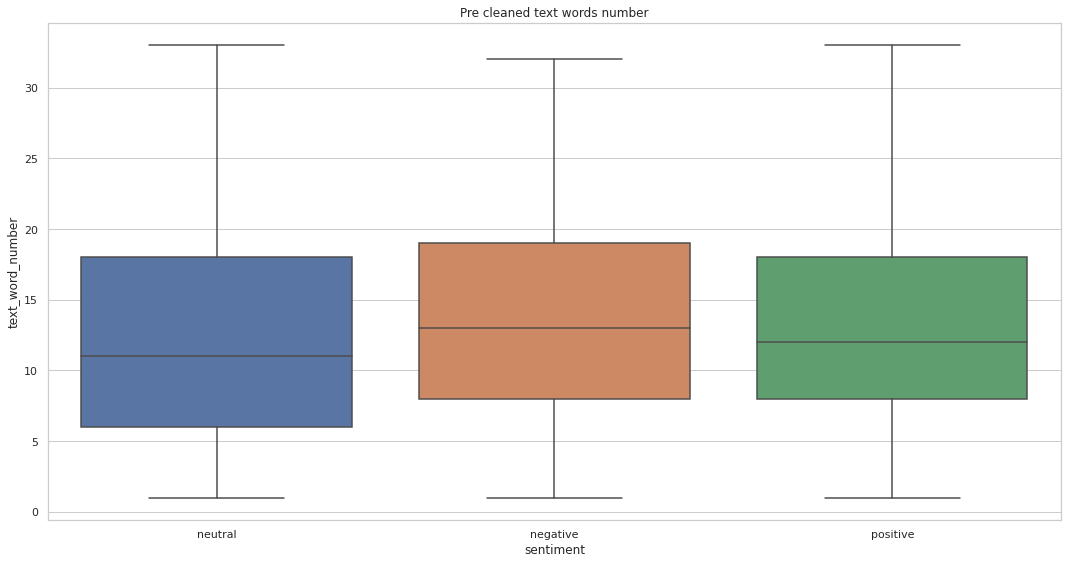

In [91]:
full_df.loc[:, "text_len"] = full_df.text.str.len()
full_df.loc[:, "text_word_number"] = full_df.text.apply(lambda text: len(text.split()))

fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(x="sentiment", y="text_word_number", data=full_df, ax=ax)
ax.set_title("Pre cleaned text words number")

fig.tight_layout()

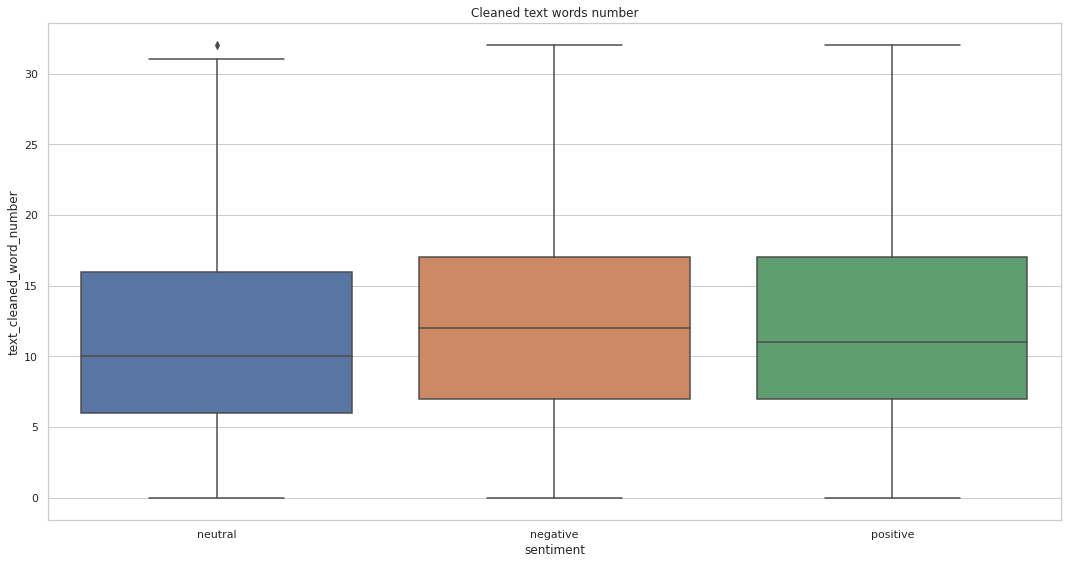

In [92]:
full_df.loc[:, "text_cleaned_len"] = full_df.text_cleaned.str.len()
full_df.loc[:, "text_cleaned_word_number"] = full_df.text_cleaned.apply(lambda text: len(text.split()))

fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(x="sentiment", y="text_cleaned_word_number", data=full_df, ax=ax)
ax.set_title("Cleaned text words number")

fig.tight_layout()

In [93]:
full_df.groupby("sentiment").text_cleaned_word_number.mean()

sentiment
negative    12.479276
neutral     11.384076
positive    12.094269
Name: text_cleaned_word_number, dtype: float64

Most common words

In [94]:
full_df.loc[:, "text_cleaned_lower"] = full_df.text_cleaned.str.lower()

In [95]:
def get_top_text_n_grams(text, n_grams=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=n_grams, stop_words="english").fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:n]


def generate_words_frequencies_by_sentiment(df, sentiments, column_name):
    word_count_by_sentiment = dict()
    for sentiment in sentiments:
        cond = df.sentiment == sentiment
        word_count_by_sentiment[sentiment] = {
            "unigram": get_top_text_n_grams(df[cond][column_name], n_grams=(1, 1)),
            "bigram": get_top_text_n_grams(df[cond][column_name], n_grams=(2, 2)),
            "trigram": get_top_text_n_grams(df[cond][column_name], n_grams=(3, 3))
        }
    
    return word_count_by_sentiment


def plot_unigrams_bigrams_trigrams(word_count_by_sentiment, groups, color_dict):
    grouped_words = ["unigram", "bigram", "trigram"]

    fig = plt.figure(figsize=(15, 8))
    for i, (kind, sentiment) in enumerate(itertools.product(grouped_words, groups), start=1):
        ax = fig.add_subplot(3, 3, i)
        word_freq_df = pd.DataFrame(word_count_by_sentiment[sentiment][kind], columns=["word", "frequency"])
        word_freq_df.sort_values(by="frequency").tail(10).plot(
            kind="barh", x="word", y="frequency", rot=0, ax=ax, title=f"{kind.capitalize()} frequencies for {sentiment} sentiment", 
            color=color_dict[sentiment])

    fig.tight_layout()

### Plot unigrams, bigrams and trigrams for training data

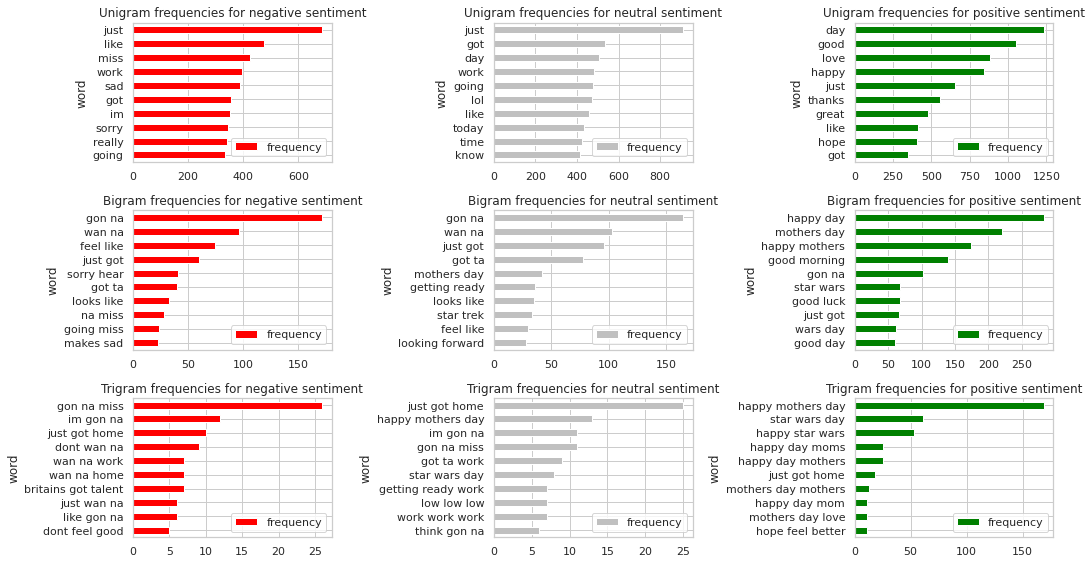

In [96]:
color_by_sentiment = {sentiment: color for sentiment, color in zip(groups, colors)}

cond_test = full_df.selected_text.isna()

word_count_by_sentiment = generate_words_frequencies_by_sentiment(full_df[~cond_test], groups, "text_cleaned_lower")
plot_unigrams_bigrams_trigrams(word_count_by_sentiment, groups, color_by_sentiment)

Plot unigrams, bigrams and trigrams for testing data

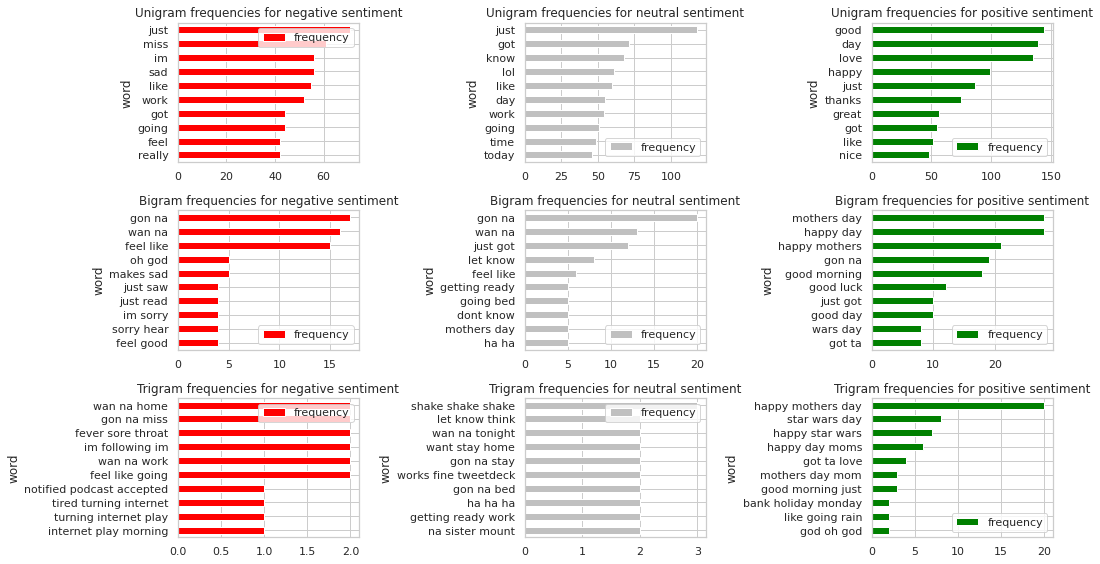

In [106]:
word_count_by_sentiment = generate_words_frequencies_by_sentiment(full_df[cond_test], groups, "text_cleaned_lower")
plot_unigrams_bigrams_trigrams(word_count_by_sentiment, groups, color_by_sentiment)

In [107]:
def generate_word_cloud(corpus, title):
    frequences_dict = pd.Series(corpus).value_counts().to_dict()
    wordcloud = WordCloud().generate_from_frequencies(frequences_dict)

    fig = plt.subplots(figsize=(20, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=32)
    plt.show()

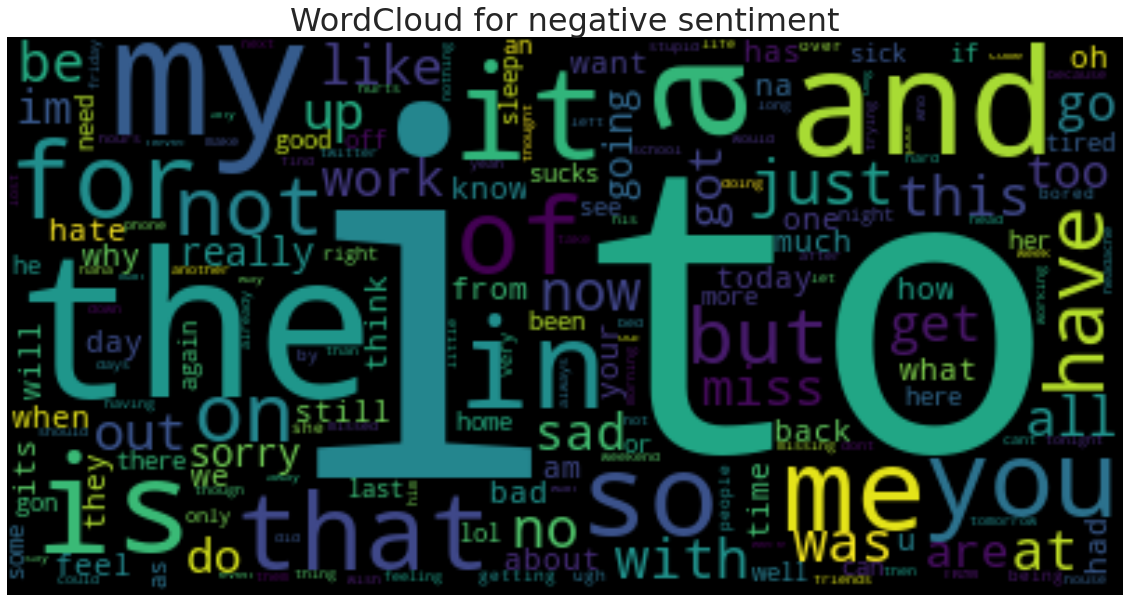

In [108]:
cond = full_df.sentiment == "negative"
text = [word for tweet in full_df[cond].text_cleaned.str.split() for word in tweet]
generate_word_cloud(text, "WordCloud for negative sentiment")

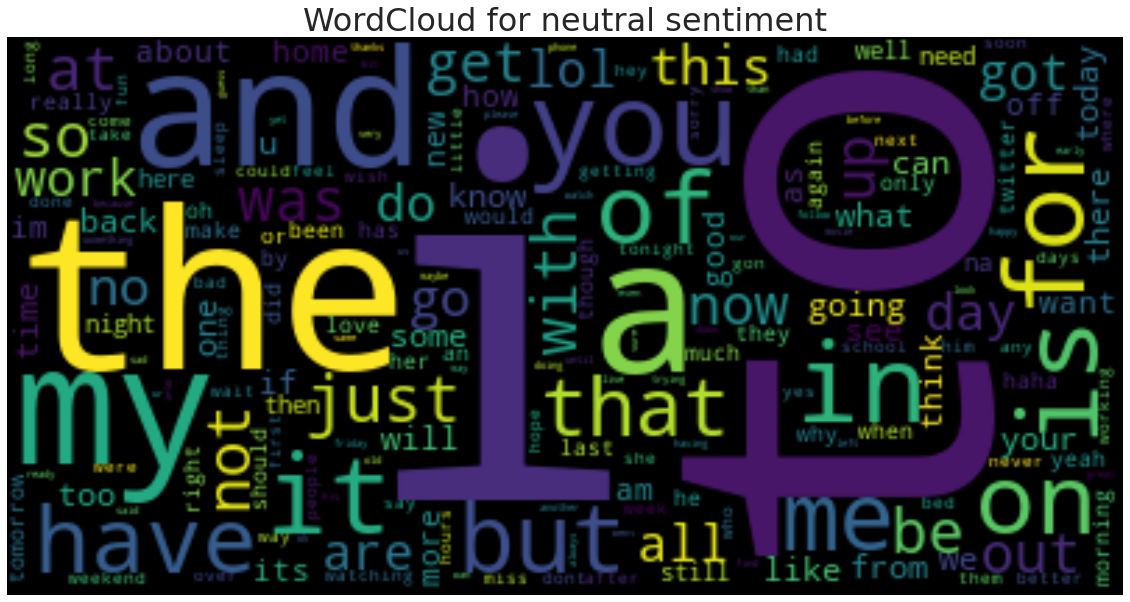

In [109]:
cond = full_df.sentiment == "neutral"
text = [word for tweet in full_df[cond].text_cleaned.str.split() for word in tweet]
generate_word_cloud(text, "WordCloud for neutral sentiment")

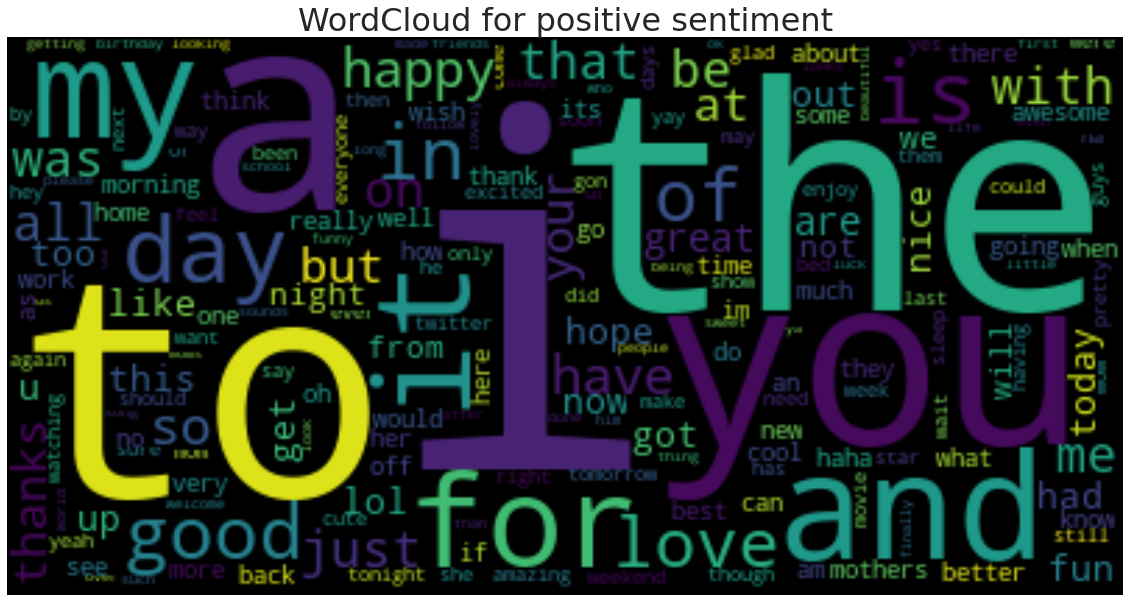

In [110]:
cond = full_df.sentiment == "positive"
text = [word for tweet in full_df[cond].text_cleaned.str.split() for word in tweet]
generate_word_cloud(text, "WordCloud for positive sentiment")

### Selected text (Target)

In [111]:
count_punctuation_df = train_df.selected_text.apply(count_punctuations)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


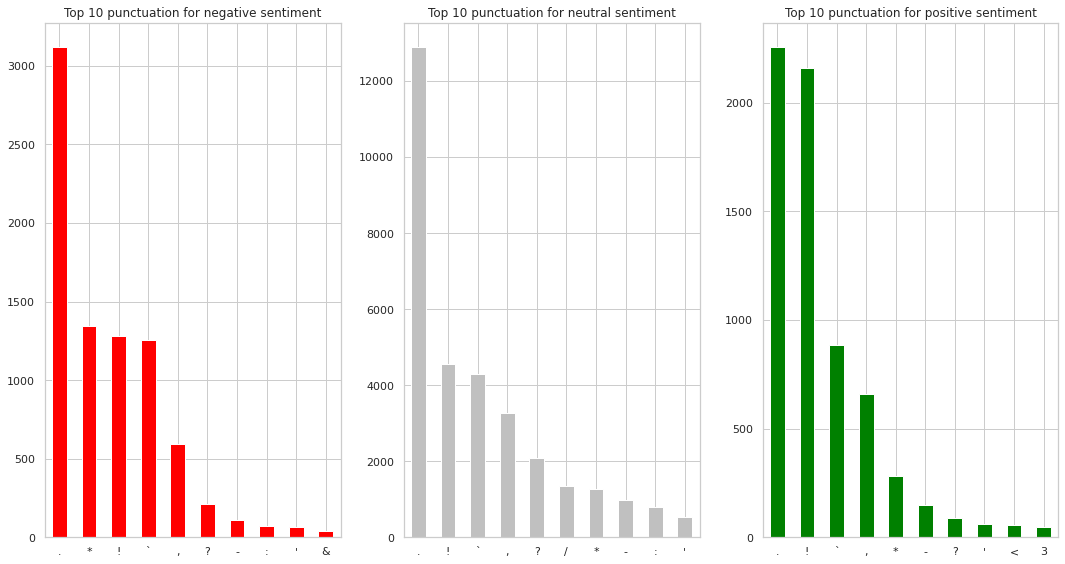

In [112]:
count_punctuation_df.loc[:, "sentiment"] = train_df.sentiment
grouped_df = count_punctuation_df.groupby("sentiment").sum()

fig = plt.figure(figsize=(15, 8))
for i, (group, color) in enumerate(zip(groups, colors), start=1):
    ax = fig.add_subplot(1, 3, i)
    grouped_df.loc[group].sort_values(ascending=False).head(10).plot(
        kind="bar", color=color, title=f"Top 10 punctuation for {group} sentiment", ax=ax, rot=0)

fig.tight_layout()

In [115]:
train_df.loc[:, "selected_text_cleaned"] = train_df.selected_text.apply(clean_text)
train_df.loc[:, "selected_text_len"] = train_df.selected_text.str.len()
train_df.loc[:, "selected_text_cleaned_len"] = train_df.selected_text_cleaned.str.len()
train_df.loc[:, "selected_text_word_number"] = train_df.selected_text_cleaned.apply(lambda text: len(text.split()))

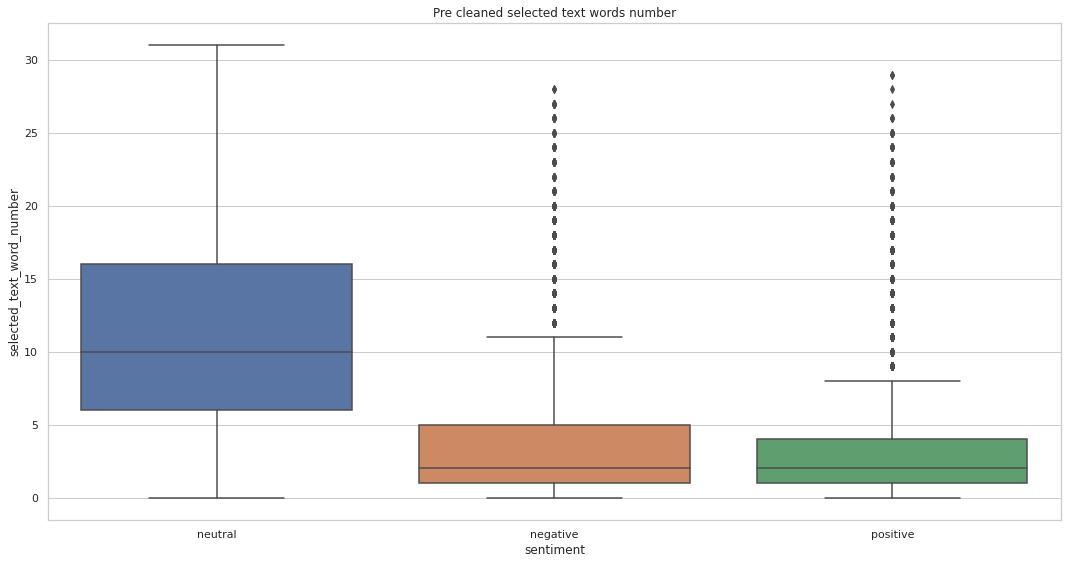

In [116]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(x="sentiment", y="selected_text_word_number", data=train_df, ax=ax)
ax.set_title("Pre cleaned selected text words number")

fig.tight_layout()

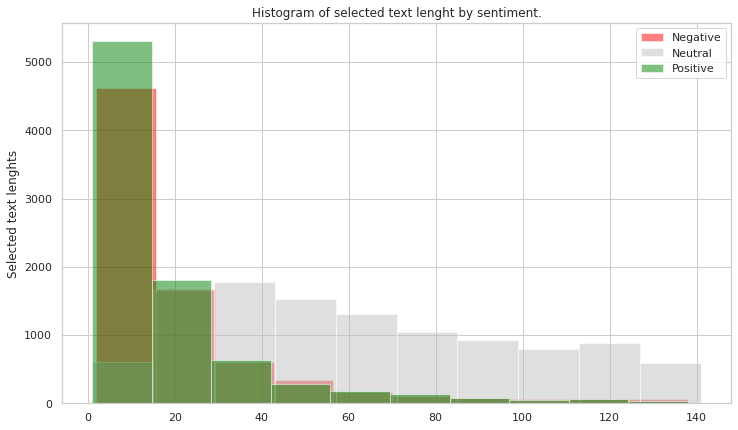

In [117]:
fig, ax = plt.subplots(figsize=(12, 7))
kwargs = dict(alpha=0.5, bins=10)
for sentiment, color in zip(groups, colors):
    selected_text_len = train_df[train_df.sentiment == sentiment].selected_text_len
    plt.hist(selected_text_len, **kwargs, color=color, label=sentiment.capitalize())

plt.gca().set(title='Histogram of selected text lenght by sentiment.', ylabel='Selected text lenghts')
_ = plt.legend()

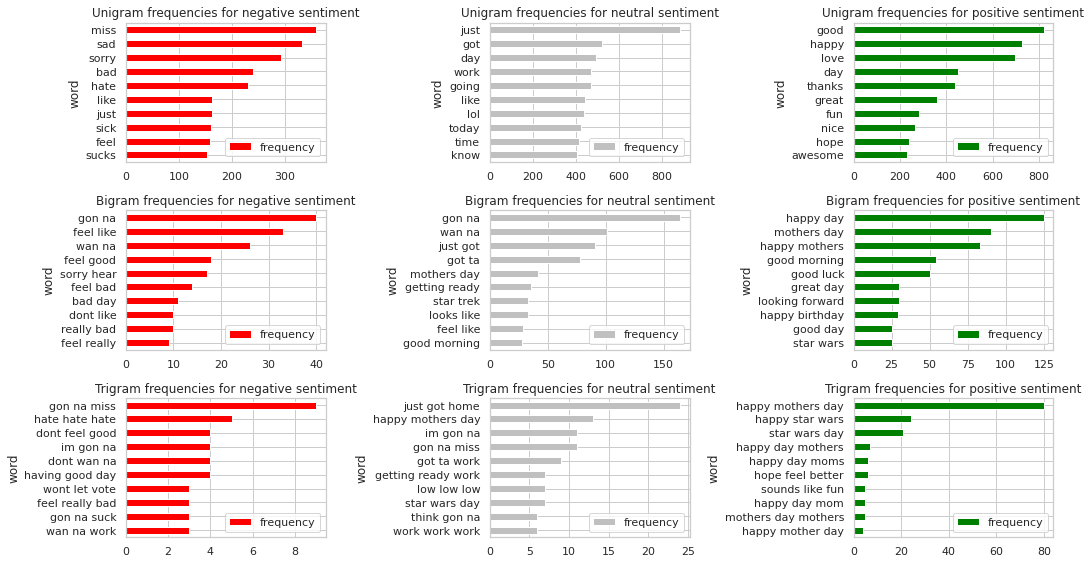

In [118]:
word_count_by_sentiment = generate_words_frequencies_by_sentiment(train_df, groups, "selected_text_cleaned")
plot_unigrams_bigrams_trigrams(word_count_by_sentiment, groups, color_by_sentiment)

### Sentiment

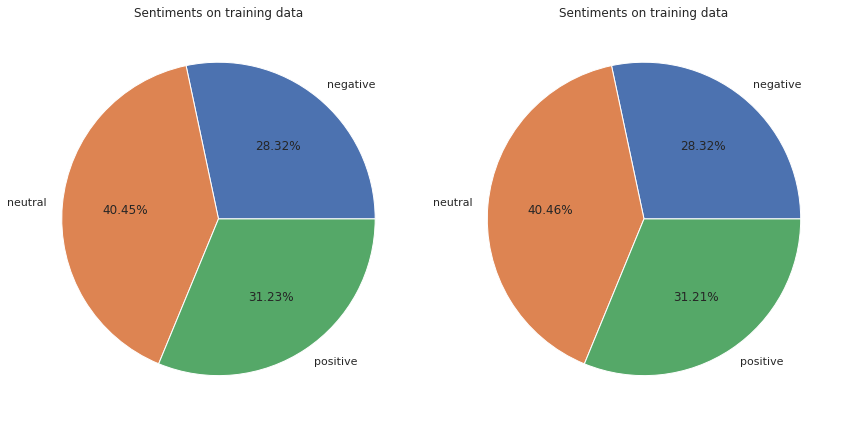

In [127]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

train_df.groupby("sentiment").size().plot(kind="pie", ax=ax1, autopct="%.2f%%", title="Sentiments on training data")
test_df.groupby("sentiment").size().plot(kind="pie", ax=ax2, autopct="%.2f%%", title="Sentiments on training data")

ax1.axis("off")
ax2.axis("off")

fig.tight_layout()